In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy import signal

In [2]:
DAFx_in, FS = sf.read('input_audios/la.wav')
n1 = 400 # analysis hop size (400 for pitch down and 150 for pitch up)
n2 = 256 # synthesis hop size (divisor of s_win)
s_win = 2048 # window length
order = 50 # cut quefrency
coef = 0.99 # sound output normalizing ratio

In [3]:
w1 = signal.windows.hann(s_win, sym=False) # analysis window
w2 = w1 # synthesis window
tscal = n2 / n1 # time-scaling ratio
print(f'tscal: {tscal}')
hs_win = s_win / 2 # half window size
print(f'hs_win: {hs_win}')
L = len(DAFx_in)
print(f'L: {L}')
DAFx_in  = np.pad(DAFx_in, (s_win, int(s_win - (L % n1))), 'constant') / np.max(np.abs(DAFx_in))
print(f'DAFx_in: {DAFx_in.shape}')

tscal: 0.64
hs_win: 1024.0
L: 22054
DAFx_in: (26096,)


In [4]:
lx = np.floor(s_win * n1 / n2)
print(f'lx: {lx}')
DAFx_out = np.zeros(int(np.ceil(tscal * len(DAFx_in))))
print(f'DAFx_out: {DAFx_out.shape}')
x = 1 + np.arange(s_win).T * lx / s_win
print(f'x: {x.shape}, {x}')
ix = np.floor(x)
print(f'ix: {ix.shape}, {ix}')
ix1= ix + 1
print(f'ix1: {ix1.shape}, {ix1}')
dx = x - ix
print(f'dx: {dx.shape}, {dx}')
dx1 = 1 - dx
print(f'dx1: {dx1.shape}, {dx1}')
warp = n1 / n2 # warpinf coefficient, = 1/tscal
print(f'warp: {warp}')
lmax = np.maximum(s_win, lx)
print(f'lmax: {lmax}')

lx: 3200.0
DAFx_out: (16702,)
x: (2048,), [1.0000000e+00 2.5625000e+00 4.1250000e+00 ... 3.1963125e+03 3.1978750e+03
 3.1994375e+03]
ix: (2048,), [1.000e+00 2.000e+00 4.000e+00 ... 3.196e+03 3.197e+03 3.199e+03]
ix1: (2048,), [2.000e+00 3.000e+00 5.000e+00 ... 3.197e+03 3.198e+03 3.200e+03]
dx: (2048,), [0.     0.5625 0.125  ... 0.3125 0.875  0.4375]
dx1: (2048,), [1.     0.4375 0.875  ... 0.6875 0.125  0.5625]
warp: 1.5625
lmax: 3200.0


In [5]:
pin = 0
pout = 0
pend = L - lmax

In [6]:
pin = 0
pout = 0
pend = L - lmax

while pin < pend:
    pin_ix = (pin + ix - 1).astype(np.int64)
#     print(f'pin_ix: {pin_ix}')
    pin_ix1 = (pin + ix1 - 1).astype(np.int64)
#     print(f'pin_ix: {pin_ix1}')
    
    # FT of interpolated grain
    grain1  = (np.take(DAFx_in, pin_ix) * dx1 + np.take(DAFx_in, pin_ix1) * dx) * w1
#     print(f'grain1: {grain1.shape}')
    f1 = np.fft.fft(grain1) / hs_win
#     print(f'f1: {f1.shape}')
    
    # FT of reference grain, for formant matching
    grain2 = DAFx_in[pin:(pin + s_win)] * w1
#     print(f'grain2: {grain2.shape}')
    f2 = np.fft.fft(grain2) / hs_win
#     print(f'f2: {f2.shape}')
    
    # correction factor for spectral enveloppe
    flog = np.log(0.00001 + np.abs(f2)) - np.log(0.00001 + np.abs(f1))
#     print(f'flog: {flog.shape}')
    cep = np.fft.ifft(flog)
#     print(f'cep: {cep.shape}')
    cep_cut = np.insert(
        arr=np.pad(cep[1:order], (0, s_win - order)),
        obj=0,
        values=cep[0] / 2
    )
#     print(f'cep_cut: {cep_cut.shape}')
    corr = np.exp(2 * np.real(np.fft.fft(cep_cut)))
#     print(f'corr: {corr.shape}')
    
    # formant move
    grain = np.fft.fftshift(np.real(np.fft.ifft(f1 * corr))) * w2
#     print(f'grain: {grain.shape}')
    
    DAFx_out[(pout):(pout + s_win)] += grain
    pin = pin + n1
    pout = pout + n2

In [7]:
DAFx_out = coef * DAFx_out[s_win:] / np.max(np.abs(DAFx_out))
print(DAFx_out.shape)
sf.write('output_audios/la_interp_move.wav', DAFx_out, FS)

(14654,)


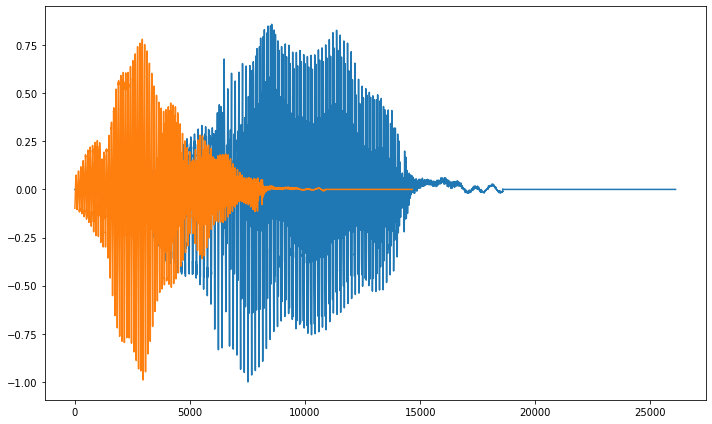

In [8]:
plt.figure(figsize=(10, 6))
# plt.subplot(121)
plt.plot(DAFx_in)
# plt.subplot(122)
plt.plot(DAFx_out)
plt.tight_layout()